# Import package


In [1]:
import os
import requests
import autograd.numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from autograd import grad, jacobian, hessian
from scipy.optimize import minimize, Bounds
import datetime
from typing import List
from numba import njit
import warnings
import numpy.linalg as la
import time
from scipy.optimize import OptimizeResult

# Data import and processing


## Online


In [2]:
settledate = pd.to_datetime(datetime.date.today())
bonds = pd.DataFrame(
    json.loads(
        requests.get(
            "https://asx.api.markitdigital.com/asx-research/1.0/bonds/government/exchange-traded?height=179&width=690"
        ).content
    )["data"]["items"]
)
bonds["maturity"] = bonds["securityDescription"].str.extract(r"(\d{2}-\d{2}-\d{2})")[0]
bonds["maturity"] = pd.to_datetime(bonds["maturity"], format="%d-%m-%y")
bonds = bonds[["maturity", "couponPercent", "priceBid", "priceAsk"]]
bonds["couponPercent"] = bonds["couponPercent"].astype(float) / 100
bonds.dropna(inplace=True)
bonds.sort_values("maturity", inplace=True)
bonds.reset_index(drop=True, inplace=True)
bonds.to_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv", index=False)
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.10,101.20
1,2027-04-21,0.0475,102.75,103.32
2,2027-11-21,0.0275,97.60,98.61
3,2028-05-21,0.0225,96.00,96.81
4,2029-04-21,0.0325,97.00,99.82
5,2033-04-21,0.0450,102.20,104.50
6,2034-12-21,0.0350,92.70,96.83
7,2037-04-21,0.0375,92.68,93.45
8,2039-06-21,0.0325,85.75,87.30
9,2047-03-21,0.0300,74.00,78.00


## Offline


In [3]:
settledate = pd.to_datetime("2025-05-18")
bonds = pd.read_csv(f"data/bonds_{settledate.strftime('%Y%m%d')}.csv")
bonds["maturity"] = pd.to_datetime(bonds["maturity"])
bonds

,maturity,couponPercent,priceBid,priceAsk
0,2025-11-21,0.0025,98.00,99.95
1,2026-04-21,0.0425,100.81,103.00
2,2027-04-21,0.0475,102.10,103.32
3,2027-11-21,0.0275,97.50,98.22
4,2028-05-21,0.0225,96.00,96.37
5,2029-04-21,0.0325,97.00,99.82
6,2033-04-21,0.0450,101.65,103.50
7,2034-12-21,0.0350,92.70,96.83
8,2037-04-21,0.0375,93.00,93.30
9,2039-06-21,0.0325,85.75,92.00


# Support function


In [4]:
def year_transform(date: pd.Timestamp) -> float:
    """Transform date to actual year"""
    if date == settledate:
        return 0
    years = date.year - settledate.year
    check_date = pd.Timestamp(
        year=date.year,
        month=settledate.month,
        day=settledate.day,
    )
    years += (date - check_date).days / abs(
        (
            check_date
            + pd.DateOffset(years=np.sign((date - check_date).days))
            - check_date
        ).days
    )
    return years


def coupon_date_generate(maturity: pd.Timestamp) -> np.ndarray:
    """Generate coupon dates"""
    coupon_dates = [maturity]
    while maturity - pd.DateOffset(months=6) > settledate:
        maturity -= pd.DateOffset(months=6)
        coupon_dates.append(maturity)
    return np.array(list(map(year_transform, coupon_dates[::-1])))


def result_to_df(
    res: OptimizeResult, param_names: list[str] = None, df: pd.DataFrame = None
) -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n - 1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)

# Discount factor curve


In [5]:
def plot(params: np.ndarray, func: callable) -> None:
    t = np.linspace(0, 30, 100000)
    dfs = func(params, t)
    plt.figure(figsize=(15, 6))
    plt.plot(t, dfs)
    plt.title("Discount Factor Curve")
    plt.xlabel("Years")
    plt.ylabel("Discount Factor")
    plt.grid()
    plt.show()

# Basic functions


In [6]:
def discount_factor(params: np.ndarray, t: np.ndarray) -> np.ndarray:
    """Calculate discount factor"""
    f0 = params[0]
    f1 = params[1]
    f2 = params[2]
    gamma = params[3]
    if gamma == 0:
        return np.exp(-f0 * t)
    if gamma < 0:
        raise ValueError("Gamma must be positive")
    res = -(
        f0 * t
        + f1 * (gamma - np.exp(-t / gamma) * gamma)
        + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
    )
    return np.exp(res)


def bond_valuation(params: np.ndarray, t: np.ndarray, coupon: float) -> float:
    """Calculate bond valuation"""
    cf = np.ones_like(t) * coupon / 2
    cf[-1] += 1
    return 100 * np.sum(cf * discount_factor(params, t))


def loss_function_component(
    params: np.ndarray, t: np.ndarray, coupon: float, bid: float, ask: float
) -> float:
    """Objective function for optimization"""
    bond_price = bond_valuation(params, t, coupon)
    if np.abs(bond_price) >= 1e154:
        return np.inf
    return (max(0, bond_price - ask) / ask) ** 2 + (max(0, bid - bond_price) / bid) ** 2

# Optimizing function


In [7]:
def constrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                params,
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

In [8]:
def unconstrained_target(params: np.ndarray) -> float:
    """Target function to be minimized"""
    return np.sum(
        [
            loss_function_component(
                np.array([params[0], params[1], params[2], np.exp(params[3])]),
                coupon_date_generate(row["maturity"]),
                row["couponPercent"],
                row["priceBid"],
                row["priceAsk"],
            )
            for _, row in bonds.iterrows()
        ]
    )

## Library method for components


In [9]:
from autograd import grad, jacobian

jac_library = grad(constrained_target)
hess_library = jacobian(grad(constrained_target))

## Analytical method for components


In [10]:
from manual_grad.analytical_grad import loss_function_component_gradient_analytical
from manual_grad.analytical_grad import loss_function_component_hessian_analytical
import numpy as onp


def jac_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate jacobian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_analytical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_analytical(params: np.ndarray) -> np.ndarray:
    """Calculate hessian using analytical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_analytical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

## Numerical method for components


In [11]:
from manual_grad.numerical_grad import loss_function_component_gradient_numerical
from manual_grad.numerical_grad import loss_function_component_hessian_numerical
import numpy as onp


def jac_numerical(params: np.ndarray, tolerance: float = 1e-5) -> np.ndarray:
    """Calculate jacobian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_gradient_numerical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        element,
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
        ]
    )


def hess_numerical(params: np.ndarray, tolerance: float = 1e-4) -> np.ndarray:
    """Calculate hessian using numerical method"""
    return np.array(
        [
            np.sum(
                [
                    loss_function_component_hessian_numerical(
                        onp.array(params),
                        coupon_date_generate(row["maturity"]),
                        row["couponPercent"],
                        row["priceBid"],
                        row["priceAsk"],
                        [element, element2],
                        tolerance=tolerance,
                    )
                    for _, row in bonds.iterrows()
                ]
            )
            for element in range(len(params))
            for element2 in range(len(params))
        ]
    ).reshape(len(params), len(params))

# Comparing gradient and hessian calulcating methods


## Gradient

### Speed

#### Library

In [12]:
%%timeit
jac_library(np.array([0.01, 0.01, 0.01, 0.01]))

24.2 ms ± 588 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Analytical

In [13]:
%%timeit
jac_analytical(np.array([0.01, 0.01, 0.01, 0.01]))

79 ms ± 786 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Numerical

In [14]:
%%timeit
jac_numerical(np.array([0.01, 0.01, 0.01, 0.01]), tolerance=1e-5)

77.2 ms ± 857 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Accuracy

#### Library agains analytical

In [15]:
error = []
for i in range(100):
    params = np.random.rand(4) * 0.1
    params[3] = np.exp(params[3])
    error.append(la.norm(jac_library(params) - jac_analytical(params)))
print("Mean error:", np.mean(error))
print("Standard deviation error", np.std(error))

Mean error: 1.4137777111619678e-14
Standard deviation error 2.0238295098164004e-14


#### Numerical agains analytical

In [16]:
error = []
for i in range(100):
    params = np.random.rand(4) * 0.1
    params[3] = np.exp(params[3])
    error.append(la.norm(jac_numerical(params, 1e-5) - jac_analytical(params)))
print("Mean error:", np.mean(error))
print("Standard deviation error", np.std(error))

Mean error: 3.3643544006834e-06
Standard deviation error 4.259096671228559e-06


# Scipy Benchmarking

- Numpy has to be used for SciPy’s optimizers, imported as onp to avoid confusion


### Helper functions


In [17]:
from scipy.optimize import OptimizeResult


def result_to_df(
    res: OptimizeResult,
    param_names: list[str] = None,
    df: pd.DataFrame = None,
    type: str = "con",
) -> pd.DataFrame:
    """
    Convert a scipy OptimizeResult into a pandas DataFrame row, appending to an existing df if provided.

    Parameters
    ----------
    res : OptimizeResult
        The result object returned by scipy.optimize.minimize (or similar).
    param_names : list of str, optional
        Names for the elements of res.x. If None, defaults to ['x0','x1',...].
    df : pandas.DataFrame, optional
        Existing DataFrame to which the new row will be appended. If None, a new DataFrame is created.

    Returns
    -------
    df_out : pandas.DataFrame
        DataFrame with the new result row added at the end.
    """
    # Ensure res.x is array
    x = np.atleast_1d(res.x)
    n = x.shape[0]
    # Determine param names
    if param_names is None:
        param_names = [f"f{i}" for i in range(n)]
        param_names[n - 1] = "gamma"
    elif len(param_names) != n:
        raise ValueError(f"param_names length {len(param_names)} != len(res.x) {n}")
    # Build row dict
    row = {name: float(val) for name, val in zip(param_names, x)}
    row["x"] = x[3]
    row["gamma"] = np.exp(x[3]) if type == "uncon" else x[3]
    # Standard OptimizeResult attributes
    for attr in ("fun", "nit", "nfev", "njev", "status"):  # numeric
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    for attr in ("success", "message"):  # boolean or text
        if hasattr(res, attr):
            row[attr] = getattr(res, attr)
    # Create or append to DataFrame
    row_df = pd.DataFrame([row])
    if df is None:
        return row_df
    else:
        # preserve column order: union of existing and new
        return pd.concat([df, row_df], ignore_index=True)


# Example usage:
# df = None
# df = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'], df=df)
# df = result_to_df(res_bfgs, param_names=['beta0','beta1','beta2','eta'], df=df)
# df['gamma'] = np.exp(df['eta'])
# print(df)
# df_pr = result_to_df(res_pr, param_names=['beta0','beta1','beta2','eta'])
# df_pr['gamma'] = np.exp(df_pr['eta'])
# print(df_pr)

In [18]:
# recover the true gamma
def true_gamma(res):
    beta0, beta1, beta2, eta_opt = res.x
    gamma_opt = np.exp(eta_opt)
    print("Optimized NS params:", [beta0, beta1, beta2, gamma_opt])
    print("Final loss:", res.fun)

### Data Setup


In [19]:
import numpy as onp

# AUTOGRAD grad / hessian
grad_ag = grad(constrained_target)
hess_ag = hessian(constrained_target)

# Convert AUTOGRAD -> numpy
fun = lambda x: float(constrained_target(np.array(x)))
jac = lambda x: onp.array(grad(constrained_target)(np.array(x)))
hess = lambda x: onp.array(hessian(constrained_target)(np.array(x)))
hessp = lambda x, p: onp.array(hessian(constrained_target)(np.array(x)).dot(p))

# shared x0 + bounds
x0 = onp.array([5, -1, 1, 1.5])  # FOR BOTH CONSTRAINED & UNCON? 5,-1,1,1.5
bnds = [(-onp.inf, onp.inf)] * 3 + [(0, onp.inf)]
bobj = Bounds(*zip(*bnds))

In [20]:
# make autodiff versions
grad_uncon = grad(unconstrained_target)

# boundary lambdas that convert ArrayBox → float / ndarray
fun_uncon = lambda y: float(unconstrained_target(np.array(y)))
jac_uncon = lambda y: onp.array(grad_uncon(np.array(y)))

# initial guess + (no bounds on y, since gamma = exp(eta) is always >0)
y0 = onp.array([5, -1, 1, onp.log(1.5)])  # FOR UNCONSTRAINED

# Prepare a container for histories
histories = {}

### Conjugate Gradient (CG, Polak–Ribiere: variety of Fletcher–Reeves)


In [21]:
from optimize import davidon_fletcher_powell

In [22]:
losses_cg = []
times_cg = []
t0 = time.perf_counter()


def cb_cg(xk):
    # xk is the current iterate
    losses_cg.append(unconstrained_target(xk))
    times_cg.append(time.perf_counter() - t0)


# CG (Polak–Ribière nonlinear conjugate‐gradient algorithm (with occasional restarts))
res_pr = davidon_fletcher_powell(
    fun_uncon,
    y0,
    jac=grad_uncon,
    # method="CG",
    callback=cb_cg,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["CG"] = {"loss": losses_cg, "time": times_cg}
res_pr

 message: Change of fun is within tolerence
 success: True
  status: 0
     fun: 1.470244778578752e-05
       x: [ 1.586e-02  2.155e-02  1.186e-01  4.183e+00]
     nit: 24
    nfev: 283
    njev: 154

In [23]:
losses_cg = []
times_cg = []
t0 = time.perf_counter()


def cb_cg(xk):
    # xk is the current iterate
    losses_cg.append(unconstrained_target(xk))
    times_cg.append(time.perf_counter() - t0)


# CG (Polak–Ribière nonlinear conjugate‐gradient algorithm (with occasional restarts))
res_pr = minimize(
    fun_uncon,
    y0,
    jac=grad_uncon,
    method="CG",
    callback=cb_cg,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["CG"] = {"loss": losses_cg, "time": times_cg}
res_pr

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 3.1819802353405045e-05
       x: [ 1.397e+00 -1.358e+00 -5.171e-01  6.755e+00]
     nit: 159
     jac: [ 1.384e-07 -3.704e-07 -7.296e-07 -6.521e-07]
    nfev: 533
    njev: 511

In [24]:
print(true_gamma(res_pr))

Optimized NS params: [1.396525577570328, -1.3575416279316288, -0.5171001682850043, 858.7164618183195]
Final loss: 3.1819802353405045e-05
None


In [25]:
performances = result_to_df(res_pr, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.5171,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.


### Newton-CG & Trust-Region Newton


In [26]:
losses_ncg = []
times_ncg = []
t0 = time.perf_counter()


def cb_ncg(xk):
    losses_ncg.append(fun_uncon(xk))
    times_ncg.append(time.perf_counter() - t0)


res_newton = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    hessp=hessp,
    method="Newton-CG",
    callback=cb_ncg,
    options={"xtol": 1e-8, "maxiter": 300},
)

histories["Newton-CG"] = {"loss": losses_ncg, "time": times_ncg}

In [27]:
print("Newton-CG →", res_newton.x, res_newton.fun)
print(true_gamma(res_newton))
res_newton

Newton-CG → [ 1.61017635 -1.59058531 -1.11596579  5.0480632 ] 0.03142466500400878
Optimized NS params: [1.6101763494800436, -1.590585305840031, -1.1159657865501387, 155.72057337845143]
Final loss: 0.03142466500400878
None


 message: Warning: Maximum number of iterations has been exceeded.
 success: False
  status: 1
     fun: 0.03142466500400878
       x: [ 1.610e+00 -1.591e+00 -1.116e+00  5.048e+00]
     nit: 300
     jac: [-5.022e-02 -2.218e-01  1.594e-01 -1.015e-01]
    nfev: 348
    njev: 348
    nhev: 339

In [28]:
performances = result_to_df(res_newton, df=performances, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...


### L-BFGS-B


In [29]:
losses_lbfgsb = []
times_lbfgsb = []
t0 = time.perf_counter()


def cb_lbfgsb(xk):
    losses_lbfgsb.append(fun_uncon(xk))
    times_lbfgsb.append(time.perf_counter() - t0)


res_L_BFGS_B = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bnds,
    method="L-BFGS-B",
    callback=cb_lbfgsb,
    options={"ftol": 1e-9, "maxiter": 300},
)
histories["L-BFGS-B"] = {"loss": losses_lbfgsb, "time": times_lbfgsb}
res_L_BFGS_B

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 1.3492190492169155e-05
        x: [ 6.142e-02 -2.404e-02 -1.219e-02  8.086e+00]
      nit: 32
      jac: [ 1.171e-04  1.330e-05  9.844e-06 -2.814e-07]
     nfev: 60
     njev: 60
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [30]:
performances = result_to_df(res_L_BFGS_B, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH


### BFGS


In [31]:
losses_bfgs = []
times_bfgs = []
t0 = time.perf_counter()


def cb_bfgs(y):
    losses_bfgs.append(fun_uncon(y))
    times_bfgs.append(time.perf_counter() - t0)


res_bfgs = minimize(
    fun=fun_uncon,
    x0=y0,
    jac=jac_uncon,
    method="BFGS",
    callback=cb_bfgs,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["BFGS"] = {"loss": losses_bfgs, "time": times_bfgs}
res_bfgs

/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)


  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.5216008065555755
        x: [ 2.197e+00 -3.339e+00  5.980e-01  1.100e+00]
      nit: 1
      jac: [ 1.941e-01 -6.417e-01  4.914e-01 -1.637e+00]
 hess_inv: [[ 1.223e+02  9.672e+01  1.998e+01 -3.894e+01]
            [ 9.672e+01  7.797e+01  1.603e+01 -3.139e+01]
            [ 1.998e+01  1.603e+01  4.238e+00 -6.228e+00]
            [-3.894e+01 -3.139e+01 -6.228e+00  1.286e+01]]
     nfev: 24
     njev: 12

In [32]:
if res_bfgs.success:
    print(true_gamma(res_bfgs))
res_bfgs

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 6.5216008065555755
        x: [ 2.197e+00 -3.339e+00  5.980e-01  1.100e+00]
      nit: 1
      jac: [ 1.941e-01 -6.417e-01  4.914e-01 -1.637e+00]
 hess_inv: [[ 1.223e+02  9.672e+01  1.998e+01 -3.894e+01]
            [ 9.672e+01  7.797e+01  1.603e+01 -3.139e+01]
            [ 1.998e+01  1.603e+01  4.238e+00 -6.228e+00]
            [-3.894e+01 -3.139e+01 -6.228e+00  1.286e+01]]
     nfev: 24
     njev: 12

In [33]:
performances = result_to_df(res_bfgs, df=performances, type="uncon")
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...


### SLSQP (General Constrained NLP)


In [34]:
losses_slsqp = []
times_slsqp = []
t0 = time.perf_counter()


def cb_slsqp(xk):
    losses_slsqp.append(fun(xk))
    times_slsqp.append(time.perf_counter() - t0)


res_slsqp = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    bounds=bobj,
    method="SLSQP",
    callback=cb_slsqp,
    options={"ftol": 1e-9, "maxiter": 300},
)
histories["SLSQP"] = {"loss": losses_slsqp, "time": times_slsqp}
res_slsqp

/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: overflow encountered in exp
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/s

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.4066222914813934e-05
       x: [ 5.940e-02 -2.186e-02 -1.456e-02  6.173e+00]
     nit: 35
     jac: [ 1.335e-04 -3.428e-05  2.789e-05 -7.379e-07]
    nfev: 72
    njev: 35

In [35]:
performances = result_to_df(res_slsqp, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully


### Trust-constr (General Constrained NLP)


In [36]:
losses_trust = []
times_trust = []
t0 = time.perf_counter()


def cb_trust(xk, state):
    # trust-constr callback signature takes (xk, OptimizeResult)
    losses_trust.append(fun_uncon(xk))
    times_trust.append(time.perf_counter() - t0)


res_trust = minimize(
    fun=fun,
    x0=x0,
    jac=jac,
    hess=hess,
    bounds=bobj,
    method="trust-constr",
    callback=cb_trust,
    options={"gtol": 1e-8, "maxiter": 300},
)
histories["Trust-constr"] = {"loss": losses_trust, "time": times_trust}
res_trust

           message: `gtol` termination condition is satisfied.
           success: True
            status: 1
               fun: 1.3146517703206194e-05
                 x: [ 6.595e-02 -2.867e-02 -4.190e-03  1.500e+01]
               nit: 272
              nfev: 229
              njev: 169
              nhev: 169
          cg_niter: 557
      cg_stop_cond: 4
              grad: [-2.275e-10  1.655e-10  3.853e-10 -6.621e-09]
   lagrangian_grad: [-2.275e-10  1.655e-10  3.853e-10 -7.271e-09]
            constr: [array([ 6.595e-02, -2.867e-02, -4.190e-03,  1.500e+01])]
               jac: [<4x4 sparse matrix of type '<class 'numpy.float64'>'
                    	with 4 stored elements in Compressed Sparse Row format>]
       constr_nfev: [0]
       constr_njev: [0]
       constr_nhev: [0]
                 v: [array([ 0.000e+00,  0.000e+00,  0.000e+00, -6.504e-10])]
            method: tr_interior_point
        optimality: 7.271315219308304e-09
  constr_violation: 0.0
    execution_time: 20.

In [37]:
performances = result_to_df(res_trust, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully
5,0.065947,-0.028666,-0.004190,14.997719,14.997719,0.000013,272,229,169,1,True,`gtol` termination condition is satisfied.


In [38]:
performances["algo"] = ["CG", "Newton-CG", "L-BFGS-B", "BFGS", "SLSQP", "Trust-constr"]
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message,algo
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.,CG
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...,Newton-CG
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,L-BFGS-B
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...,BFGS
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully,SLSQP
5,0.065947,-0.028666,-0.004190,14.997719,14.997719,0.000013,272,229,169,1,True,`gtol` termination condition is satisfied.,Trust-constr


# Manual implementation

In [39]:
from optimize import davidon_fletcher_powell, fletcher_reeves, gradient_projection, zoutendijk

In [40]:
losses = []
times = []
t0 = time.perf_counter()

def generic_callback(xk):
    # xk is the current iterate
    losses.append(unconstrained_target(xk))
    times.append(time.perf_counter() - t0)

res_dfp = davidon_fletcher_powell(
    fun_uncon,
    y0,
    jac=grad_uncon,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["DFP"] = {"loss": losses, "time": times}

In [41]:
performances = result_to_df(res_dfp, df=performances)
res_dfp

 message: Change of fun is within tolerence
 success: True
  status: 0
     fun: 1.470244778578752e-05
       x: [ 1.586e-02  2.155e-02  1.186e-01  4.183e+00]
     nit: 24
    nfev: 283
    njev: 154

In [42]:
losses = []
times = []
t0 = time.perf_counter()

res_fr = fletcher_reeves(
    fun_uncon,
    y0,
    jac=grad_uncon,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["FR"] = {"loss": losses, "time": times}

/opt/conda/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_14258/2761773010.py:13: RuntimeWarning: invalid value encountered in subtract
  + f1 * (gamma - np.exp(-t / gamma) * gamma)
/tmp/ipykernel_14258/2761773010.py:14: RuntimeWarning: invalid value encountered in subtract
  + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
/tmp/ipykernel_14258/2761773010.py:13: RuntimeWarning: invalid value encountered in subtract
  + f1 * (gamma - np.exp(-t / gamma) * gamma)
/tmp/ipykernel_14258/2761773010.py:14: RuntimeWarning: invalid value encountered in subtract
  + f2 * (gamma - np.exp(-t / gamma) * (t + gamma))
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:48: RuntimeWarning: invalid value encountered in subtract
  return f_raw(*args, **kwargs)
/opt/conda/lib/python3.11/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output see

In [43]:
performances = result_to_df(res_fr, df=performances)
res_fr

 message: Norm of gradient is within tolerence
 success: True
  status: 0
     fun: 0.0
       x: [      -inf       -inf       -inf        inf]
     nit: 3
    nfev: 88
    njev: 46

In [44]:
losses = []
times = []
t0 = time.perf_counter()

res_gp = gradient_projection(
    fun,
    x0,
    jac=jac,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["grad_proj"] = {"loss": losses, "time": times}

In [45]:
performances = result_to_df(res_gp, df=performances)
res_gp

 message: Change of x is within tolerence
 success: True
  status: 0
     fun: 2.0905407768766655
       x: [ 7.560e-01 -7.667e-01 -1.300e+00  3.921e+00]
     nit: 10
    nfev: 323
    njev: 167
     jac: [ 1.473e+00 -2.107e+00  8.514e-01 -7.067e-01]

In [47]:
losses = []
times = []
t0 = time.perf_counter()

res_z = zoutendijk(
    fun,
    x0,
    jac=jac,
    callback=generic_callback,
    options={"gtol": 1e-6, "maxiter": 300},
)
histories["zoutendijk"] = {"loss": losses, "time": times}
res_z

/opt/conda/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


 message: Change of x is within tolerence
 success: True
  status: 0
     fun: 1.3620661744586293
       x: [ 1.549e+00 -1.243e+00 -3.002e+00  6.497e+00]
     nit: 209
    nfev: 6086
    njev: 3148
     jac: [ 2.646e-01  3.158e-02 -1.478e-01 -1.484e-01]

In [48]:
performances = result_to_df(res_z, df=performances)
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message,algo
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.,CG
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...,Newton-CG
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,L-BFGS-B
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...,BFGS
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully,SLSQP
5,0.065947,-0.028666,-0.004190,14.997719,14.997719,0.000013,272,229,169,1,True,`gtol` termination condition is satisfied.,Trust-constr
6,0.015860,0.021554,0.118577,4.182978,4.182978,0.000015,24,283,154,0,True,Change of fun is within tolerence,NaN
7,-inf,-inf,-inf,inf,inf,0.000000,3,88,46,0,True,Norm of gradient is within tolerence,NaN
8,0.756037,-0.766675,-1.299557,3.921431,3.921431,2.090541,10,323,167,0,True,Change of x is within tolerence,NaN
9,1.548552,-1.243348,-3.002265,6.496868,6.496868,1.362066,209,6086,3148,0,True,Change of x is within tolerence,NaN


# View results

In [49]:
performances["algo"] = ["CG", "Newton-CG", "L-BFGS-B", "BFGS", "SLSQP", "Trust-constr", "DFP", "FR", "grad_proj", "zoutendijk"]
performances

,f0,f1,f2,gamma,x,fun,nit,nfev,njev,status,success,message,algo
0,1.396526,-1.357542,-0.517100,858.716462,6.755439,0.000032,159,533,511,0,True,Optimization terminated successfully.,CG
1,1.610176,-1.590585,-1.115966,155.720573,5.048063,0.031425,300,348,348,1,False,Warning: Maximum number of iterations has been...,Newton-CG
2,0.061423,-0.024040,-0.012191,8.086305,8.086305,0.000013,32,60,60,0,True,CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH,L-BFGS-B
3,2.197378,-3.338956,0.598015,3.005209,1.100347,6.521601,1,24,12,2,False,Desired error not necessarily achieved due to ...,BFGS
4,0.059399,-0.021861,-0.014560,6.172718,6.172718,0.000014,35,72,35,0,True,Optimization terminated successfully,SLSQP
5,0.065947,-0.028666,-0.004190,14.997719,14.997719,0.000013,272,229,169,1,True,`gtol` termination condition is satisfied.,Trust-constr
6,0.015860,0.021554,0.118577,4.182978,4.182978,0.000015,24,283,154,0,True,Change of fun is within tolerence,DFP
7,-inf,-inf,-inf,inf,inf,0.000000,3,88,46,0,True,Norm of gradient is within tolerence,FR
8,0.756037,-0.766675,-1.299557,3.921431,3.921431,2.090541,10,323,167,0,True,Change of x is within tolerence,grad_proj
9,1.548552,-1.243348,-3.002265,6.496868,6.496868,1.362066,209,6086,3148,0,True,Change of x is within tolerence,zoutendijk


### Plot target func value over iterations and time

99th percentile loss: 3559021.526610566


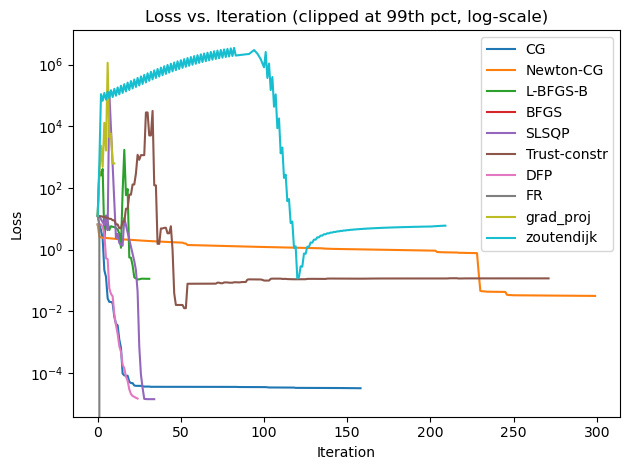

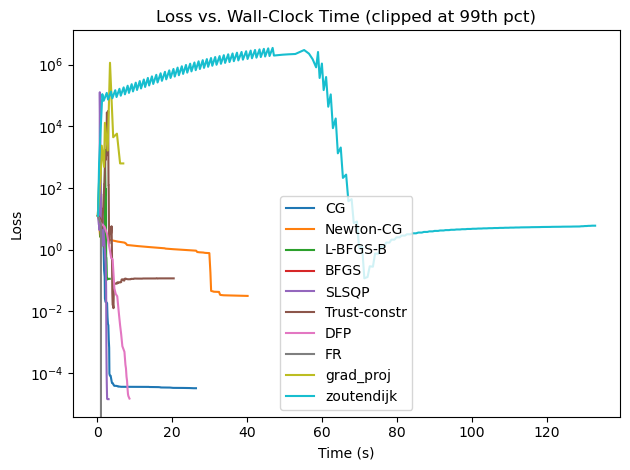

In [50]:
# stack and filter finite losses
all_losses = onp.hstack(
    [onp.array(h["loss"])[onp.isfinite(h["loss"])] for h in histories.values() if "loss" in h]
)

# high‐end cutoff (e.g. the 99th percentile)
cutoff = onp.percentile(all_losses, 99)
print("99th percentile loss:", cutoff)

plt.figure()
for name, h in histories.items():
    if "loss" in h:
        loss = onp.array(h["loss"])
        mask = onp.isfinite(loss) & (loss <= cutoff)
        plt.plot(onp.nonzero(mask)[0], loss[mask], label=name)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss vs. Iteration (clipped at 99th pct, log-scale)")
plt.legend()
plt.tight_layout()
plt.savefig("loss_vs_iteration_clipped.pdf")
plt.show()

plt.figure()
for name, h in histories.items():
    if "loss" in h:
        loss = onp.array(h["loss"])
        time_steps = onp.array(h["time"])
        # same mask as before
        mask = onp.isfinite(loss) & (loss <= cutoff)
        # plot time_steps vs. loss
        plt.plot(time_steps[mask], loss[mask], label=name)
plt.xlabel("Time (s)")
plt.ylabel("Loss")
plt.title("Loss vs. Wall-Clock Time (clipped at 99th pct)")
plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig("loss_vs_time_clipped.pdf")
plt.show()

### Export the run results into excel/csv

In [51]:
pip install XlsxWriter # install this to export

Note: you may need to restart the kernel to use updated packages.


In [52]:
histories["initial_pt_constrained"] = {"x0": x0}
latest_idx = 0

def next_excel_filename(
    prefix: str, directory: str = ".", x0: onp.ndarray = None, global_index=latest_idx
) -> str:
    """
    Find the next Excel filename for histories, e.g. 'histories_run_0001.xlsx'
    or, if x0 is provided:
      'histories_run_0001_(5_-1_0-52_1-5).xlsx'
    """
    existing = [
        f
        for f in os.listdir(directory)
        if f.startswith(f"{prefix}_run_") and f.endswith(".xlsx")
    ]
    idxs = []
    for f in existing:
        try:
            idx = int(f.split("_run_")[1].split(".xlsx")[0].split("(")[0])
            idxs.append(idx)
        except ValueError:
            continue
    next_idx = max(idxs) + 1 if idxs else 1

    fname = f"{prefix}_run_{next_idx:04d}"
    global_index = next_idx
    return fname + ".xlsx"


# Generate the next Excel filename with x0 in it
hist_excel = next_excel_filename("histories", x0=x0)

# Write histories to Excel with each solver as a separate sheet
with pd.ExcelWriter(hist_excel, engine="xlsxwriter") as writer:
    for solver, data in histories.items():
        if "x0" in data:
            df = pd.DataFrame({"x0": data["x0"]})
        else:
            df = pd.DataFrame({"loss": data["loss"], "time": data["time"]})
        sheet_name = solver[:31]  # stick to Excel's 31-char limit
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Saved history workbook to {hist_excel}")

# And similarly for performances (as CSV, if you like)
perf_filename = hist_excel.replace("histories", "performances").replace(".xlsx", ".csv")
performances.to_csv(perf_filename, index=False)
print(f"Saved performances to {perf_filename}")

Saved history workbook to histories_run_0002.xlsx
Saved performances to performances_run_0002.csv


# Hayoung!!!


In [ ]:
def is_positive_semidefinite(H: np.ndarray) -> bool:
    eigenvalues = np.linalg.eigvalsh(H)
    return np.all(eigenvalues >= 0)


param_grid = [
    [f0, f1, f2, gamma]
    for f0 in np.linspace(-5, 5, 10)
    for f1 in np.linspace(-5, 5, 10)
    for f2 in np.linspace(-5, 5, 10)
    for gamma in np.linspace(1, 20, 10)
]

for params in param_grid:
    H = hess_analytical(params)
    if not is_positive_semidefinite(H):
        print("❌ Not PSD at:", params)

In [ ]:
initial_params = np.array([100, 100, 100, 18])
target_grad = grad(target)

result = minimize(
    fun=target,
    x0=initial_params,
    method="BFGS",  # Quasi-Newton
    jac=target_grad,
    options={"disp": True},
)

In [ ]:
print(result.success)
print(result.x)
print(result.fun)

In [ ]:
est_gamma = result.x[3]
est_f3 = result.x[2]
est_f3, est_gamma

In [ ]:
import autograd.numpy as np


f2_fixed = 0



gamma_fixed = 17



# f0, f1 범위 좁게



f0_vals = np.linspace(-0.1, 0.1, 100)



f1_vals = np.linspace(-0.1, 0.1, 100)



F0, F1 = np.meshgrid(f0_vals, f1_vals)



Z = np.zeros_like(F0)



# 손실 계산



for i in range(F0.shape[0]):

    for j in range(F0.shape[1]):

        params = np.array([F0[i, j], F1[i, j], f2_fixed, gamma_fixed])

        Z[i, j] = target(params)


def wrapped(params_2d):

    f0, f1 = params_2d

    return target(np.array([f0, f1, f2_fixed, gamma_fixed]))



grad_func = grad(wrapped)



start = np.array([0.1, 0.1])



trace = [start.copy()]



def callback(xk):

    trace.append(xk.copy())



res = minimize(wrapped, start, method="BFGS", jac=grad_func, callback=callback)



# 2d plot



trace = np.array(trace)



plt.figure(figsize=(8, 6))



plt.contourf(F0, F1, Z, levels=50, cmap="viridis")



plt.plot(trace[:, 0], trace[:, 1], "r.-", label="Optimization Path")



plt.scatter(res.x[0], res.x[1], color="white", edgecolor="black", label="Optimum")



plt.xlabel("f0")



plt.ylabel("f1")



plt.title("Optimization Path on Loss Surface")



plt.xlim(-0.1, 0.1)



plt.ylim(-0.1, 0.1)
plt.legend()



plt.colorbar()



plt.show()

In [ ]:
trace = np.array(trace)
plt.figure(figsize=(8, 6))
plt.contourf(F0, F1, Z, levels=50, cmap="viridis")
plt.plot(trace[:, 0], trace[:, 1], "r.-", label="Optimization Path")
plt.scatter(res.x[0], res.x[1], color="white", edgecolor="black", label="Optimum")
plt.xlabel("f0")
plt.ylabel("f1")
plt.title("Optimization Path on Loss Surface")
plt.xlim(-0.05, 0.101)
plt.ylim(-0.1, 0.101)
plt.legend()
plt.colorbar()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

gamma_fixed = est_gamma

f0_vals = np.linspace(-0.05, 0.1, 10)
f1_vals = np.linspace(-0.1, 0.1, 10)
f2_vals = np.linspace(-0.1, 0.1, 10)

f0_list = []
f1_list = []
f2_list = []
loss_list = []

for f0 in f0_vals:
    for f1 in f1_vals:
        for f2 in f2_vals:
            params = np.array([f0, f1, f2, gamma_fixed])
            loss = target(params)
            f0_list.append(f0)
            f1_list.append(f1)
            f2_list.append(f2)
            loss_list.append(loss)

f0_arr = np.array(f0_list)
f1_arr = np.array(f1_list)
f2_arr = np.array(f2_list)
loss_arr = np.array(loss_list)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

sc = ax.scatter(
    f0_arr, f1_arr, f2_arr, c=loss_arr, cmap="viridis", s=30, vmin=0.0, vmax=0.1
)

ax.set_xlabel("f0 (Level)")
ax.set_ylabel("f1 (Slope)")
ax.set_zlabel("f2 (Curvature)")
ax.set_title(f"Loss Surface (γ = {gamma_fixed}, zoomed range)")

cbar = plt.colorbar(sc, label="Loss")
cbar.ax.set_ylabel("Loss (scaled to [0, 0.1])")

plt.show()